In [35]:
from pykeen import datasets
import pykeen.datasets.analysis as analysis
import pandas as pd
from tqdm import tqdm
import seaborn as sns

In [36]:
dataset = datasets.Wikidata5M()

In [37]:
dataset.summarize()

You're trying to map triples with 156 entities and 0 relations that are not in the training set. These triples will be excluded from the mapping.
In total 156 from 5133 triples were filtered out
You're trying to map triples with 180 entities and 0 relations that are not in the training set. These triples will be excluded from the mapping.
In total 180 from 5163 triples were filtered out


Wikidata5M (create_inverse_triples=False)
Name        Entities    Relations      Triples
----------  ----------  -----------  ---------
Training    4594149     822           20614279
Testing     4594149     822               4977
Validation  4594149     822               4983
Total       -           -             20624239
Head    Relation    tail
------  ----------  --------
Q1      P1343       Q602358
Q1      P1419       Q1647152
Q1      P1552       Q11412
Q1      P2184       Q136407
Q1      P2670       Q18343



In [38]:
train = pd.read_csv(
    dataset.training_path,
    sep="\t",
    names=["head", "relation", "tail"],
    encoding="utf-8",
)
train.index.name = "id"
train

,head,relation,tail
id,,,
0,Q29387131,P31,Q5
1,Q326660,P1412,Q652
2,Q7339549,P57,Q1365729
3,Q554335,P27,Q29999
4,Q20641639,P54,Q80955
...,...,...,...
20614274,Q7179406,P131,Q1439
20614275,Q5363458,P19,Q60
20614276,Q6891853,P31,Q5


In [39]:
len(set(list(train["head"]) + list(train["tail"])))

4594149

In [40]:
test = pd.read_csv(
    dataset.testing_path, sep="\t", names=["head", "relation", "tail"], encoding="utf-8"
)
test.index.name = "id"
test

,head,relation,tail
id,,,
0,Q7965079,P27,Q16
1,Q6719921,P31,Q11446
2,Q4925109,P175,Q5165801
3,Q11010724,P734,Q59853
4,Q1236794,P31,Q1134686
...,...,...,...
5128,Q221157,P47,Q951695
5129,Q952206,P47,Q506745
5130,Q801344,P131,Q6874


In [41]:
valid = pd.read_csv(
    dataset.validation_path,
    sep="\t",
    names=["head", "relation", "tail"],
    encoding="utf-8",
)
valid.index.name = "id"
valid

,head,relation,tail
id,,,
0,Q3576734,P495,Q30
1,Q641724,P1412,Q1860
2,Q959357,P39,Q49476
3,Q4263990,P105,Q7432
4,Q4119101,P171,Q2906912
...,...,...,...
5158,Q2609942,P156,Q2611606
5159,Q1797671,P106,Q33999
5160,Q601973,P31,Q5


In [42]:
def get_nodes_representation(df, base_df):
    unique_nodes = list(
        set(list(df["head"]) + list(df["tail"]))
        & set(list(base_df["head"]) + list(base_df["tail"]))
    )
    nodes = {node: [] for node in unique_nodes}

    # where node is a head
    base_df = base_df.reset_index().set_index("head")

    for i, row in tqdm(base_df.iterrows(), total=len(base_df)):
        if i in nodes.keys():
            nodes[i].append(("head", row["relation"], row["tail"]))

    base_df = base_df.reset_index().set_index("tail")

    # where node is a tail
    for i, row in tqdm(base_df.iterrows(), total=len(base_df)):
        if i in nodes.keys():
            nodes[i].append(("tail", row["relation"], row["head"]))

    return nodes

In [43]:
nodes_train = get_nodes_representation(df=train, base_df=train)
nodes_test = get_nodes_representation(df=test, base_df=train)
nodes_valid = get_nodes_representation(df=valid, base_df=train)

100%|██████████| 20614279/20614279 [33:36<00:00, 10224.16it/s]


[Text(0.5, 1.0, 'Distribution of neighbourhood sizes of train nodes in the Wikidata5M train subset')]

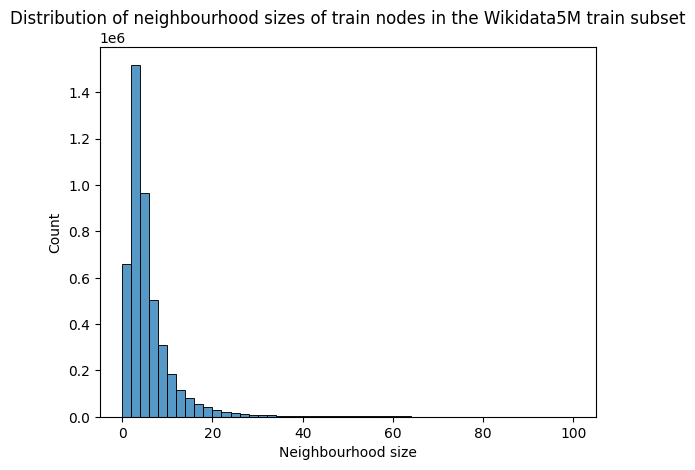

In [44]:
temp_df = pd.DataFrame(
    [len(nodes_train[x]) for x in nodes_train.keys()],
    columns=["Neighbourhood size"],
)
sns.histplot(data=temp_df, x="Neighbourhood size", binwidth=2, binrange=(0, 100)).set(
    title="Distribution of neighbourhood sizes of train nodes in the Wikidata5M train subset"
)

In [45]:
temp_df.mean(), temp_df.median()

(Neighbourhood size    8.974145
 dtype: float64,
 Neighbourhood size    4.0
 dtype: float64)

[Text(0.5, 1.0, 'Distribution of neighbourhood sizes of test nodes in the Wikidata5M train subset')]

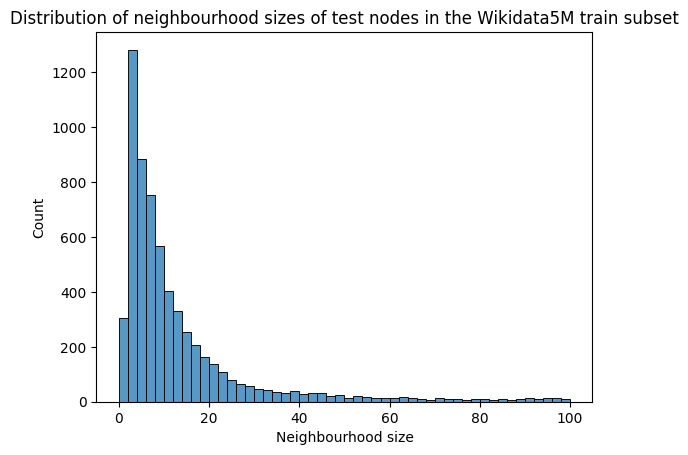

In [46]:
temp_df = pd.DataFrame(
    [len(nodes_test[x]) for x in nodes_test.keys()],
    columns=["Neighbourhood size"],
)
sns.histplot(data=temp_df, x="Neighbourhood size", binwidth=2, binrange=(0, 100)).set(
    title="Distribution of neighbourhood sizes of test nodes in the Wikidata5M train subset"
)

In [47]:
temp_df.mean(), temp_df.median()

(Neighbourhood size    1403.148058
 dtype: float64,
 Neighbourhood size    10.0
 dtype: float64)

[Text(0.5, 1.0, 'Distribution of neighbourhood sizes of valid nodes in the Wikidata5M train subset')]

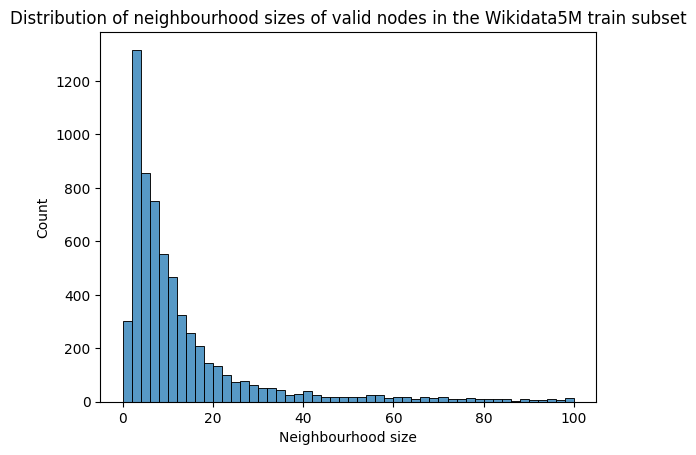

In [48]:
temp_df = pd.DataFrame(
    [len(nodes_valid[x]) for x in nodes_valid.keys()],
    columns=["Neighbourhood size"],
)
sns.histplot(data=temp_df, x="Neighbourhood size", binwidth=2, binrange=(0, 100)).set(
    title="Distribution of neighbourhood sizes of valid nodes in the Wikidata5M train subset"
)

In [49]:
temp_df.mean(), temp_df.median()

(Neighbourhood size    1405.261442
 dtype: float64,
 Neighbourhood size    10.0
 dtype: float64)

## Testing dropping entities that are not in the train KG

In [50]:
def filter_only_train_entities(df, base_df):
    df_unique_nodes = set(list(df["head"]) + list(df["tail"]))
    common_unique_nodes = df_unique_nodes & set(list(base_df["head"]) + list(base_df["tail"]))

    nodes2drop = df_unique_nodes - common_unique_nodes
    return df[(df['tail'].apply(lambda x: x not in nodes2drop)) & (df['head'].apply(lambda x: x not in nodes2drop))].reset_index(drop=True)

In [51]:
filter_only_train_entities(test, train)

,head,relation,tail
0,Q7965079,P27,Q16
1,Q6719921,P31,Q11446
2,Q4925109,P175,Q5165801
3,Q11010724,P734,Q59853
4,Q1236794,P31,Q1134686
...,...,...,...
4972,Q221157,P47,Q951695
4973,Q952206,P47,Q506745
4974,Q801344,P131,Q6874
4975,Q7638539,P106,Q488205


In [52]:
filter_only_train_entities(valid, train)

,head,relation,tail
0,Q3576734,P495,Q30
1,Q641724,P1412,Q1860
2,Q959357,P39,Q49476
3,Q4263990,P105,Q7432
4,Q4119101,P171,Q2906912
...,...,...,...
4978,Q2609942,P156,Q2611606
4979,Q1797671,P106,Q33999
4980,Q601973,P31,Q5
4981,Q6109958,P81,Q17055414
